In [1]:
import json
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from results import Results

In [2]:
def save(model, filename: str, model_name: str):
    """Saves the model to an .h5 file and the model name to a .json file.

    Args:
        model: Model to be saved
        filename: Relative path to the file without the extension.
        
    """
    # Save Keras model
    model.save(filename + '.h5')

    # Save base model information
    with open(filename + '.json', 'w', encoding='utf-8') as f:
        json.dump(model_name, f, ensure_ascii=False, indent=4, sort_keys=True)

In [3]:
train_datagen = ImageDataGenerator(
        # reducing/normalizing the pixels
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2) 
#We dont want the dataset to be flipped as orientation is important, so we delete the horizontal_flip parameter
#connecting the image augmentation tool to our dataset

targetSizeWidth = 112
targetSizeHeight = 112
targetSize = (targetSizeWidth, targetSizeHeight)
batchSize = 32


train_set = train_datagen.flow_from_directory(
        'D:/DatosMBD/train',
        target_size = targetSize,
        batch_size=batchSize,
        class_mode='categorical')

#only rescaling but no transformations
validation_datagen = ImageDataGenerator(rescale=1./255)
val_set = validation_datagen.flow_from_directory(
        'D:/DatosMBD/validation/',
        target_size = targetSize,
        batch_size = batchSize,
        class_mode = 'categorical')
#only rescaling but no transformations

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        'D:/DatosMBD/test',
        target_size = targetSize,
        batch_size = batchSize,
        class_mode = 'categorical')


Found 35175 images belonging to 5 classes.
Found 5019 images belonging to 5 classes.
Found 10055 images belonging to 5 classes.


In [4]:
def _plot_training(history):
    """Plots the evolution of the accuracy and the loss of both the training and validation sets.

    Args:
        history: Training history.

    """
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(training_accuracy))

    # Accuracy
    plt.figure()
    plt.plot(epochs, training_accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()




Training CNN...
Epoch 1/10
32/32 [==============================] - 19s 513ms/step - loss: 0.4056 - accuracy: 0.5195 - val_loss: 0.2448 - val_accuracy: 0.7695
Epoch 2/10
32/32 [==============================] - 17s 536ms/step - loss: 0.2135 - accuracy: 0.7979 - val_loss: 0.1621 - val_accuracy: 0.8516
Epoch 3/10
32/32 [==============================] - 16s 487ms/step - loss: 0.1397 - accuracy: 0.8818 - val_loss: 0.0977 - val_accuracy: 0.9141
Epoch 4/10
32/32 [==============================] - 16s 488ms/step - loss: 0.0951 - accuracy: 0.9219 - val_loss: 0.0848 - val_accuracy: 0.9346
Epoch 5/10
32/32 [==============================] - 16s 520ms/step - loss: 0.0889 - accuracy: 0.9287 - val_loss: 0.0836 - val_accuracy: 0.9258
Epoch 6/10
32/32 [==============================] - 16s 493ms/step - loss: 0.0675 - accuracy: 0.9424 - val_loss: 0.0616 - val_accuracy: 0.9502
Epoch 7/10
32/32 [==============================] - 14s 442ms/step - loss: 0.0648 - accuracy: 0.9434 - val_loss: 0.0686 - va

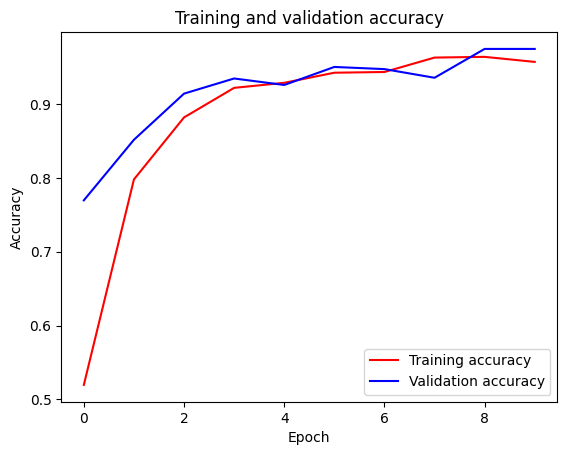

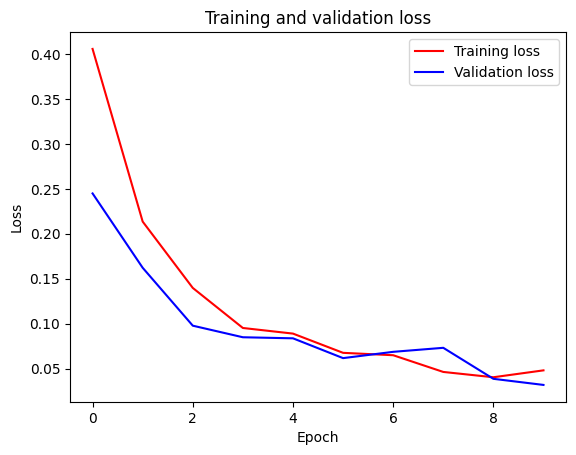

In [5]:
#--------------------- Building CNN --------------------#
# initializing CNN as sequential layers
from keras.callbacks import EarlyStopping
def create_model():
        
    cnn = tf.keras.models.Sequential()
    # Step 1: Convolution to get the Feature Map
    cnn.add(tf.keras.layers.Conv2D(filters= 64 , kernel_size = 2, activation = 'relu', input_shape=[targetSize[0],targetSize[1],3]))
    # filters: output feature map
    # kernel_size: size of the feature detector
    # strides: step size from one filter to the next default is 1
    # Step 2: Max Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2 ,strides=2))
    #adding a second convolutional layer
    cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 2,padding='same', activation = 'relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2 ,strides=2))
    #adding a second convolutional layer
    cnn.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 2,padding='same', activation = 'relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2 ,strides=2))
    #adding a second convolutional layer
    cnn.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 2,padding='same', activation = 'relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2 ,strides=2))
    # Step 3: Flattening
    cnn.add(tf.keras.layers.Flatten())

    # Step 4: Full Connection
    cnn.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))

    # Step 5: Output Layer
    cnn.add(tf.keras.layers.Dense(units = 5, activation = 'sigmoid'))
    return cnn

#--------------------- Training the CNN --------------------#
#compiling the CNN
cnn=create_model()
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#training the CNN on the training set and evaluating it on the test set
# cnn.fit(x = train_set, validation_data = test_set, epochs = 25)
epochs=10
# callbacks=
# Train the network
print("\n\nTraining CNN...")
# Monitor in real-time the training and validation accuracy and loss
early_stopping_monitor = EarlyStopping(patience=4)
batch_size = 32
history = cnn.fit(
    train_set,
    epochs=epochs,
    steps_per_epoch=batch_size,
    validation_data=train_set,
    validation_steps=batch_size,
    callbacks=[early_stopping_monitor]
    #callbacks=callbacks
)
if epochs > 1:
    _plot_training(history)


In [6]:
def predict(self, test_dir: str, dataset_name: str = "", save: bool = True):
    """Evaluates a new set of images using the trained CNN.

    Args:
        test_dir: Relative path to the validation directory (e.g., 'dataset/test').
        dataset_name: Dataset descriptive name.
        save: Save results to an Excel file.

    """
    # Configure loading and pre-processing functions
    print('Reading test data...')
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=self._preprocessing_function)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=self._target_size,
        batch_size=1,  # A batch size of 1 ensures that all test images are processed
        class_mode='categorical',
        shuffle=False
    )

    # Predict categories
    predictions = self._model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1).ravel().tolist()

    # Format results and compute classification statistics
    results = Results(test_generator.class_indices, dataset_name=dataset_name)
    accuracy, confusion_matrix, classification = results.compute(test_generator.filenames, test_generator.classes,
                                                                    predicted_labels)
    # Display and save results
    results.print(accuracy, confusion_matrix)

    if save:
        results.save(confusion_matrix, classification, predictions)

In [10]:
from keras.utils import load_img, img_to_array
#--------------------- Single prediction with CNN --------------------#
test_image = load_img('D:/DatosMBD/validation/Pablo/Pablo0.jpg', target_size = (112, 112))
# to convert image in pii format into a numpy array format
test_image = img_to_array(test_image)
# adding extra dimension to put this image into a batch by saying where we want to add this batch (as the first dimension)
test_image = np.expand_dims(test_image, axis = 0)
# cnn prediction on the test image
result = cnn.predict(test_image)
# getting the results encoding: which indices correspond to which classes (1: dog, 0:cat)
print(train_set.class_indices)

#prediction for the single image/element from the batch
if result[0][0] == 0:
   prediction = 'JuanM'
elif result[0][0] == 1:
   prediction = 'JuanO'
else:
   prediction = 'Pablo'

print(prediction)


test_image2 = load_img('D:/DatosMBD/validation/JuanM/JuanM0.jpg', target_size = (112, 112))
# to convert image in pii format into a numpy array format
test_image2 = img_to_array(test_image2)
# adding extra dimension to put this image into a batch by saying where we want to add this batch (as the first dimension)
test_image2 = np.expand_dims(test_image2, axis = 0)
# cnn prediction on the test image
result2 = cnn.predict(test_image2)

#prediction for the single image/element from the batch
if result[0][0] == 0:
   prediction = 'JuanM'
elif result[0][0] == 1:
   prediction = 'JuanO'
else:
   prediction = 'Pablo'

print(prediction)

1/1 [==============================] - 0s 30ms/step
{'FaceDetectionDataFull': 0, 'JuanM': 1, 'JuanO': 2, 'Pablo': 3, 'noFaceData': 4}
JuanM
1/1 [==============================] - 0s 26ms/step
JuanM
